# Introduction
This notebook is dedicated to sampling the synthetic MATSIM population, based on a geographical area. It must be run after extracting the population's attributes from the MATSIM output file.

# Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import requests
import io
import gzip
import zipfile
from collections import defaultdict
from tqdm import tqdm
from numpy.linalg import norm
from tqdm.notebook import tqdm
from scipy import spatial
sns.set_palette('colorblind')
sns.set_theme()
tqdm.pandas()
# RNG
rng = np.random.default_rng(seed=42)

# Filtering the individuals of a specific geographical area
In order to restrict the population to a certain geographical area, we'll need the administrative location of every individual in the sample.  
To do so, we'll use the data from the [Official Directory of building addresses](https://www.cadastre.ch/en/services/service/registry/building.html). This data gives the coordinates of every building in Switzerland, alongside the municipality they are located in.  

Now, the objective is clear: for every individual in the sample, ```home_x``` and ```home_y``` give the person's home coordinates. We can then find the building that is closest to that location, and consider that it is within the same municipality as the individual's home.   
To do so efficiently, we'll use a [KD Tree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html), which allows to quickly search for the nearest neighbour in more than one dimension.

## Loading the geographical data

In [12]:
# Downloads the directory of building addresses if cannot be found at its supposed location
odba_url = 'https://data.geo.admin.ch/ch.swisstopo.amtliches-gebaeudeadressverzeichnis/csv/2056/ch.swisstopo.amtliches-gebaeudeadressverzeichnis.zip'
dest_file = '../data/geo/swiss_buildings_adresses.csv.gz'
if not os.path.exists(dest_file):
    # Downloads the zipped folder
    request = requests.get(odba_url, allow_redirects=True)
    # Extracts the CSV file of interest and writes as a GZIP file to the destination file
    with zipfile.ZipFile(io.BytesIO(request.content), "r") as zip_folder:
        with gzip.open(dest_file, 'wb') as compressed_dest_file:
            compressed_dest_file.write(zip_folder.read('pure_adr.csv'))

In [14]:
buildings_coords = pd.read_csv(dest_file, sep=';',
                              usecols=['ZIP_LABEL', 'ADR_EASTING', 'ADR_NORTHING'])
# The column ZIP_LABEL has form XXXX town_name where XXXX is the postcode of the muni
buildings_coords['postcode'] = buildings_coords['ZIP_LABEL'].apply(lambda s: int(s.split(' ')[0]))
buildings_coords.head()

,ZIP_LABEL,ADR_EASTING,ADR_NORTHING,postcode
0,3724 Ried (Frutigen),2612581,1155389,3724
1,4914 Roggwil BE,2628216,1231863,4914
2,3703 Aeschi b. Spiez,2619697,1167343,3703
3,3063 Ittigen,2603183,1203166,3063
4,2606 Corgémont,2576671,1227270,2606


In [15]:
# Generates the KDTree from the East and North coordinates of all reference points
kdtree = spatial.KDTree(buildings_coords[['ADR_EASTING', 'ADR_NORTHING']])

In [16]:
def find_postcode(indiv_data):
    """
    Given a row of the population sample dataframe,
    finds the postcode of the individual's home location
    based on the closest town location.
    """
    home_loc = np.array([indiv_data['home_x'], indiv_data['home_y']])
    # Retrieves the index of the reference point that is closest to
    # the home location
    distance, closest_town = kdtree.query(home_loc)
    return int(buildings_coords.loc[closest_town, 'postcode'])

We can now merge this dataset with the [Official Directory of towns and cities](https://www.cadastre.ch/en/services/service/registry/plz.html), which gives the postcode and municipality code of every town in Switzerland.

In [17]:
towns_coords = pd.read_csv('../data/geo/PLZO_CSV_LV95.csv', sep=';')
towns_coords = towns_coords.rename({'PLZ': 'postcode', 'BFS-Nr': 'muni_index', 'Gemeindename': 'municipality',
                                       'Ortschaftsname': 'local', 'Kantonskürzel': 'canton'}, axis=1)
towns_coords = towns_coords.drop_duplicates(subset=['postcode'])
towns_coords = towns_coords[['canton', 'local', 'postcode', 'municipality', 'muni_index']]
towns_coords.head()

,canton,local,postcode,municipality,muni_index
0,ZH,Aeugst am Albis,8914,Aeugst am Albis,1
2,ZH,Zwillikon,8909,Affoltern am Albis,2
3,ZH,Affoltern am Albis,8910,Affoltern am Albis,2
4,ZH,Bonstetten,8906,Bonstetten,3
5,ZH,Hausen am Albis,8915,Hausen am Albis,4


In [18]:
towns_coords['canton'].unique()

array(['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO',
       'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD',
       'VS', 'NE', 'GE', 'JU', nan], dtype=object)

We'll also add the town coordinates in the WGS84 format, which can be downloaded from the same source. Contrary to the LV95 coordinates format, the WGS84 is standard and can be used to build geographical charts, such as with Plotly.

In [19]:
towns_wgs84 = pd.read_csv('../data/geo/PLZO_CSV_WGS84.csv', sep=';')
towns_wgs84 = towns_wgs84.rename({'PLZ': 'postcode', 'BFS-Nr': 'muni_index', 'Gemeindename': 'municipality',
                                       'Ortschaftsname': 'local', 'Kantonskürzel': 'canton',
                                   'E': 'wgs84_e', 'N': 'wgs84_n'}, axis=1)
towns_wgs84 = towns_wgs84.drop_duplicates(subset=['postcode'])
towns_wgs84 = towns_wgs84[['postcode', 'wgs84_e', 'wgs84_n']]
towns_wgs84.head()

,postcode,wgs84_e,wgs84_n
0,8914,8.488313,47.267004
2,8909,8.431459,47.287633
3,8910,8.448945,47.279169
4,8906,8.467611,47.315510
5,8915,8.534860,47.242360


In [20]:
towns_coords = towns_coords.merge(towns_wgs84, left_on="postcode", right_on="postcode")
towns_coords.head()

,canton,local,postcode,municipality,muni_index,wgs84_e,wgs84_n
0,ZH,Aeugst am Albis,8914,Aeugst am Albis,1,8.488313,47.267004
1,ZH,Zwillikon,8909,Affoltern am Albis,2,8.431459,47.287633
2,ZH,Affoltern am Albis,8910,Affoltern am Albis,2,8.448945,47.279169
3,ZH,Bonstetten,8906,Bonstetten,3,8.467611,47.315510
4,ZH,Hausen am Albis,8915,Hausen am Albis,4,8.534860,47.242360


## Selecting a geographical area

We can now process the synthetic populations chunk by chunk, only keeping those that are in a specific area, such as a canton.

In [9]:
def is_in_area(indiv_geo_data):
    """
    Defines a geographical area of interest.
    Given the geographical data about a synthetic agent,
    returns True if and only if the agent lives within the
    area of interest.
    """
    return indiv_geo_data['canton'] == 'VD'

In [11]:
kept_rows = []
chunksize = 1000000
with pd.read_csv("../data/extracted_data/matsim_population_attributes.csv",
                 chunksize=chunksize) as full_df:
    for k, chunk in enumerate(full_df):
        # Finds the postcodes of every individual in the chunk
        chunk['postcode'] = chunk.apply(find_postcode, axis=1)
        # Merges with the associated municipality's information
        chunk = chunk.merge(towns_coords, left_on="postcode", right_on="postcode")
        chunk = chunk[is_in_area(chunk)]
        kept_rows.append(chunk)
        print(f'Processed {k} chunks - {chunksize * k} rows')
sample = pd.concat(kept_rows)
print(sample.info())

Processed 0 chunks - 0 rows
Processed 1 chunks - 1000000 rows
Processed 2 chunks - 2000000 rows
Processed 3 chunks - 3000000 rows
Processed 4 chunks - 4000000 rows
Processed 5 chunks - 5000000 rows
Processed 6 chunks - 6000000 rows
Processed 7 chunks - 7000000 rows
<class 'pandas.core.frame.DataFrame'>
Int64Index: 825576 entries, 115551 to 815280
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                825576 non-null  int64  
 1   age               825576 non-null  int64  
 2   bikeAvailability  825576 non-null  object 
 3   carAvail          825576 non-null  object 
 4   employed          825576 non-null  bool   
 5   hasLicense        825576 non-null  object 
 6   home_x            825576 non-null  float64
 7   home_y            825576 non-null  float64
 8   householdIncome   0 non-null       float64
 9   isCarPassenger    825576 non-null  bool   
 10  municipalityType  0 non-null       fl

In [12]:
sample.head()

,id,age,bikeAvailability,carAvail,employed,hasLicense,home_x,home_y,householdIncome,isCarPassenger,...,ptHasVerbund,sex,spRegion,postcode,canton,local,municipality,muni_index,wgs84_e,wgs84_n
115551,1069770,85,FOR_NONE,never,False,no,2569239.0,1190194.0,NaN,False,...,False,f,3,1580,VD,Avenches,Avenches,5451,7.040607,46.880248
115552,1103868,85,FOR_NONE,never,False,no,2569239.0,1190194.0,NaN,False,...,False,f,3,1580,VD,Avenches,Avenches,5451,7.040607,46.880248
115553,1110921,76,FOR_ALL,always,True,yes,2569193.0,1189751.0,NaN,False,...,False,m,3,1580,VD,Avenches,Avenches,5451,7.040607,46.880248
115554,1110922,70,FOR_ALL,never,False,yes,2569193.0,1189751.0,NaN,False,...,False,f,3,1580,VD,Avenches,Avenches,5451,7.040607,46.880248
115555,1111181,61,FOR_ALL,always,False,yes,2569340.0,1189900.0,NaN,False,...,False,f,3,1580,VD,Avenches,Avenches,5451,7.040607,46.880248


## Saving the sample

In [14]:
sample.to_csv('../data/abm/vaud/extracted/vaud_population.csv.gz', index=False)

# Load the sample here if required

In [2]:
sample = pd.read_csv('../data/abm/vaud/extracted/vaud_population.csv.gz')

In [3]:
# We'll need to search for individual IDs in the sample;
# using a Set will make that quicker
sample_ids = set(list(sample['id']))

# Filtering the activities of the sampled individuals
Now that we've selected only a fraction of the synthetic population, we'll need to filter the activities to only keep those performed by those individuals.

In [4]:
kept_rows = []
chunksize = 2000000
with pd.read_csv("../data/extracted_data/matsim_population_activities.csv",
                 chunksize=chunksize) as full_df:
    for k, chunk in enumerate(full_df):
        # Selects in the chunk the activities performed by agents
        # that are in the sample
        chunk = chunk[chunk['id'].isin(sample_ids)]
        kept_rows.append(chunk)
        print(f'Processed {k} chunks - {chunksize * k} rows')
sample_activities = pd.concat(kept_rows)
print(sample_activities.info())

Processed 0 chunks - 0 rows
Processed 1 chunks - 2000000 rows
Processed 2 chunks - 4000000 rows
Processed 3 chunks - 6000000 rows
Processed 4 chunks - 8000000 rows
Processed 5 chunks - 10000000 rows
Processed 6 chunks - 12000000 rows
Processed 7 chunks - 14000000 rows
Processed 8 chunks - 16000000 rows
Processed 9 chunks - 18000000 rows
Processed 10 chunks - 20000000 rows
Processed 11 chunks - 22000000 rows
Processed 12 chunks - 24000000 rows
Processed 13 chunks - 26000000 rows
Processed 14 chunks - 28000000 rows
Processed 15 chunks - 30000000 rows
Processed 16 chunks - 32000000 rows
Processed 17 chunks - 34000000 rows
Processed 18 chunks - 36000000 rows
Processed 19 chunks - 38000000 rows
Processed 20 chunks - 40000000 rows
Processed 21 chunks - 42000000 rows
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455076 entries, 423464 to 36710599
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   type        object 
 2   facili

We'll save the sampled activities:

In [5]:
sample_activities.to_csv('../data/abm/vaud/extracted/vaud_activities.csv.gz')

# Filtering the sampled individuals' trips
Finally, we'll do the same for the transportation:

In [ ]:
kept_rows = []
chunksize = 20000000
with pd.read_csv("../data/extracted_data/matsim_population_transports.csv.gz",
                 chunksize=chunksize) as full_df:
    for k, chunk in enumerate(full_df):
        # Selects in the chunk the activities performed by agents
        # that are in the sample
        chunk = chunk[chunk['id'].isin(sample_ids)]
        kept_rows.append(chunk)
        print(f'Processed {k} chunks - {chunksize * k} rows')
sample_trips = pd.concat(kept_rows)
print(sample_activities.info())

We'll save this final file:

In [15]:
sample_trips.to_csv('../data/abm/vaud/extracted/vaud_trips.csv.gz')

# Filtering the FOPH data
We'll also need to isolate the COVID-19 positive tests located in the specific geographical area that we've decided to use.

## Confirmed cases

In [6]:
foph_data = pd.read_csv('../data/foph/2021-10-22_10-03-52_BAGEPI-1086-cortes_study_data_cases.csv', sep=';',
                       usecols=['altersjahr', 'gemeinde_cd', 'ktn', 'sex', 'fall_dt'])
foph_data = foph_data.rename({'altersjahr': 'age', 'gemeinde_cd': 'muni_index',
                              'fall_dt': 'date', 'ktn': 'canton'}, axis=1)[['age', 'canton', 'sex', 'date']]
foph_data.loc[:, 'date'] = pd.to_datetime(foph_data['date'])
# Translates "Weiblich" and "Männlich" to 'f' and 'm'
foph_data = foph_data.replace({'sex': {'Weiblich': 'f', 'Männlich': 'm'}})
foph_data.head()

/tmp/ipykernel_12775/4189274652.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  foph_data.loc[:, 'date'] = pd.to_datetime(foph_data['date'])


,age,canton,sex,date
0,70.0,TI,m,2020-02-24
1,25.0,AG,m,2020-02-25
2,2.0,GR,m,2020-02-26
3,0.0,GR,m,2020-02-26
4,28.0,GE,m,2020-02-26


In [7]:
# Isolates the Vaud canton
foph_data = foph_data[foph_data['canton'] == 'VD']
foph_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88713 entries, 5 to 738578
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   age     88687 non-null  float64       
 1   canton  88713 non-null  object        
 2   sex     88713 non-null  object        
 3   date    88713 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.4+ MB


Let's observe the cases over time after filtering:

In [8]:
daily_cases = foph_data.groupby('date').count()['age'].resample('B').sum().rename('daily confirmed cases')
daily_cases.head()

date
2020-02-26    1
2020-02-27    0
2020-02-28    0
2020-03-02    5
2020-03-03    4
Freq: B, Name: daily confirmed cases, dtype: int64

In [9]:
weekly_cases = foph_data.groupby('date').count()['age'].resample('W').sum().rename('weekly confirmed cases')
weekly_cases.head()

date
2020-03-01       1
2020-03-08      57
2020-03-15     521
2020-03-22    1440
2020-03-29    1440
Freq: W-SUN, Name: weekly confirmed cases, dtype: int64

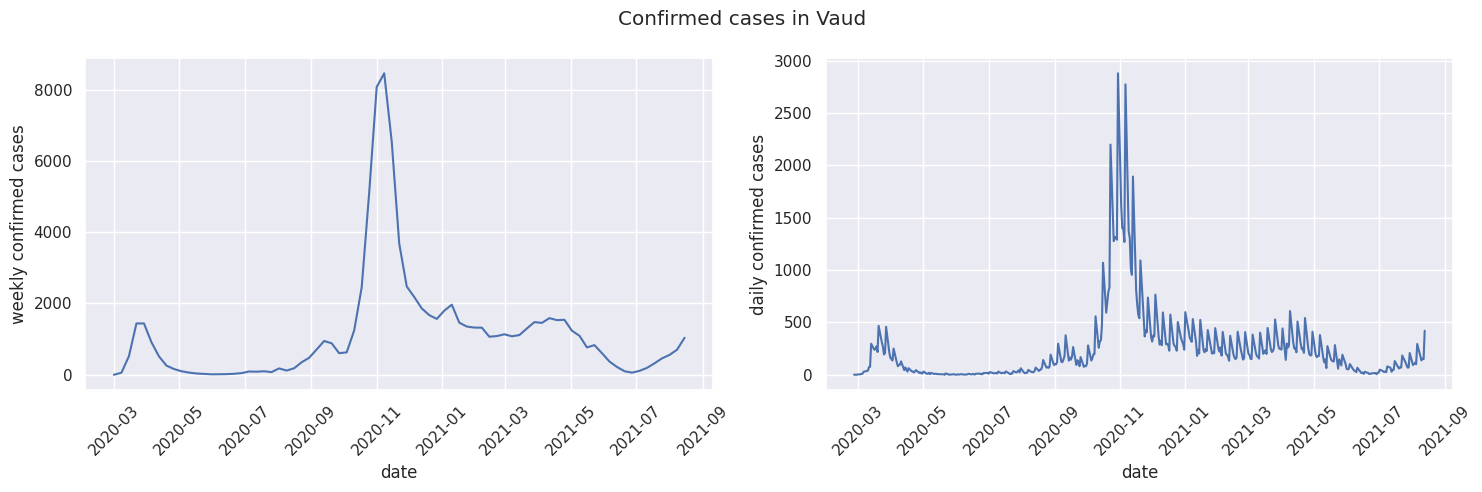

In [10]:
plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('Confirmed cases in Vaud')
plt.subplot(121)
sns.lineplot(data=weekly_cases)
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(data=daily_cases)
plt.xticks(rotation=45)
plt.show()

We can't save the filtered individual cases to avoid creating new sensible files. However we can save the aggregated weekly cases, which is actually public information:

In [11]:
weekly_cases.reset_index().to_csv('../data/abm/vaud/prepared/vaud_weekly_cases.csv.gz', index=False)
daily_cases.reset_index().to_csv('../data/abm/vaud/prepared/vaud_daily_cases.csv.gz', index=False)

## Test data
The number of tests (positive and negative), per age group and canton is publicly available on the [Swiss COVID19 Dashboard](https://www.covid19.admin.ch/en/epidemiologic/test).

In [12]:
test_data = pd.read_csv('../data/foph/public/COVID19Test_geoRegion_AKL10_w.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55080 entries, 0 to 55079
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   altersklasse_covid19  55080 non-null  object 
 1   nachweismethode       55080 non-null  object 
 2   geoRegion             55080 non-null  object 
 3   datum                 55080 non-null  int64  
 4   entries               50400 non-null  float64
 5   entries_pos           50400 non-null  float64
 6   entries_neg           47547 non-null  float64
 7   sumTotal              50400 non-null  float64
 8   anteil_pos            47547 non-null  float64
 9   anteil_pos_diff       46578 non-null  float64
 10  anteil_pos_all        50140 non-null  float64
 11  freq                  50400 non-null  float64
 12  prct                  50400 non-null  float64
 13  pop                   49572 non-null  float64
 14  inz_entries           45360 non-null  float64
 15  inzsumTotal        

We'll filter the entries that refer to Vaud:

In [13]:
test_data = test_data[test_data['geoRegion'] == 'VD'].copy()
test_data.shape

(1530, 26)

According to the website, the data by canton is not available for the first weeks of 2020. Therefore we need to discard the entries that contain NaNs for the test statistics:

In [14]:
test_data = test_data.dropna(subset='entries')

We'll rename the columns in German:

In [15]:
test_data = test_data.rename({
    'altersklasse_covid19': 'age_class',
    'datum_dboardformated': 'date',
    'nachweismethode': 'test_method',
    'anteil_pos': 'positive_prct'
}, axis=1)

Some entries refer to an uknown age, but they only represent an unsignificant part of the entries:

In [16]:
n_unknown_age = test_data.query("age_class == 'Unbekannt'")['entries'].sum()
print(f"Found {n_unknown_age} unknown age entries out of {test_data['entries'].sum()} total entries")

Found 292.0 unknown age entries out of 2272239.0 total entries


We can thus remove them without creating any bias in the data:

In [17]:
test_data = test_data.query("age_class != 'Unbekannt'")

Let's now plot the total, positive and negative entries:

In [18]:
# We first need to convert the date column to the datetime format
test_data['date'] = pd.to_datetime(test_data['date'] + '-1', format="%Y-%W-%w") # -1 to choose Mondays
test_data = test_data[['date', 'age_class', 'entries', 'entries_pos', 'entries_neg', 'positive_prct']]
test_data = test_data.set_index('date')
test_data.head()

,age_class,entries,entries_pos,entries_neg,positive_prct
date,,,,,
2020-06-01,0 - 9,494.0,1.0,493.0,0.2
2020-06-01,10 - 19,290.0,2.0,288.0,0.7
2020-06-01,20 - 29,419.0,4.0,415.0,1.0
2020-06-01,30 - 39,528.0,2.0,526.0,0.4
2020-06-01,40 - 49,465.0,3.0,462.0,0.6


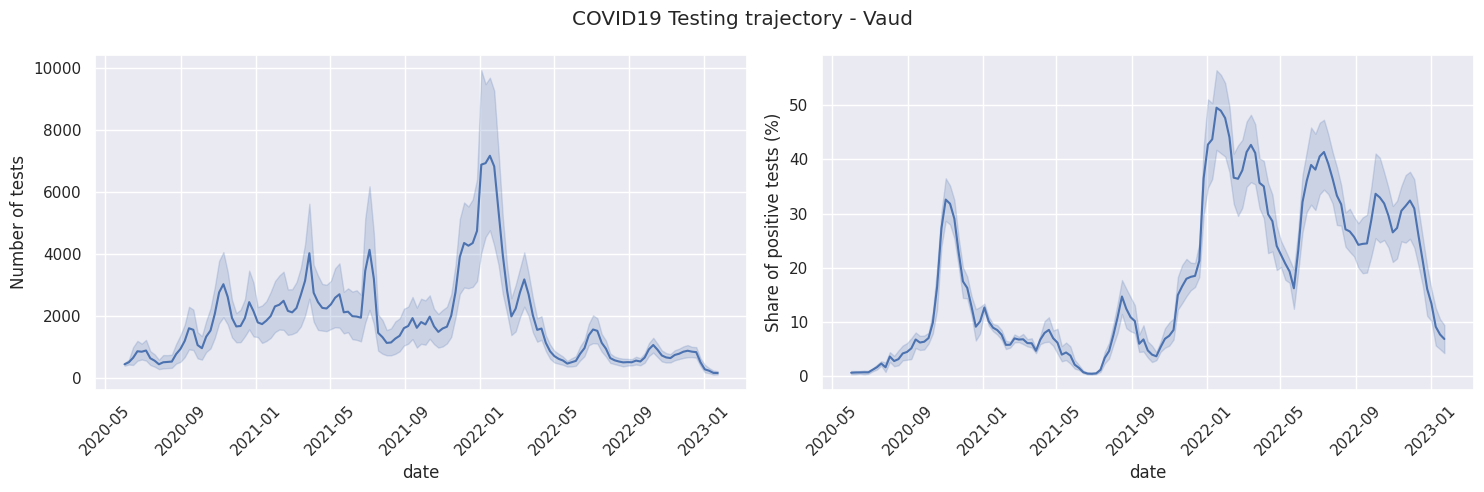

In [19]:
plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('COVID19 Testing trajectory - Vaud')
plt.subplot(121)
sns.lineplot(data=test_data, x='date', y='entries')
plt.ylabel('Number of tests')
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(data=test_data, x='date', y='positive_prct')
plt.ylabel('Share of positive tests (%)')
plt.xticks(rotation=45)
plt.show()

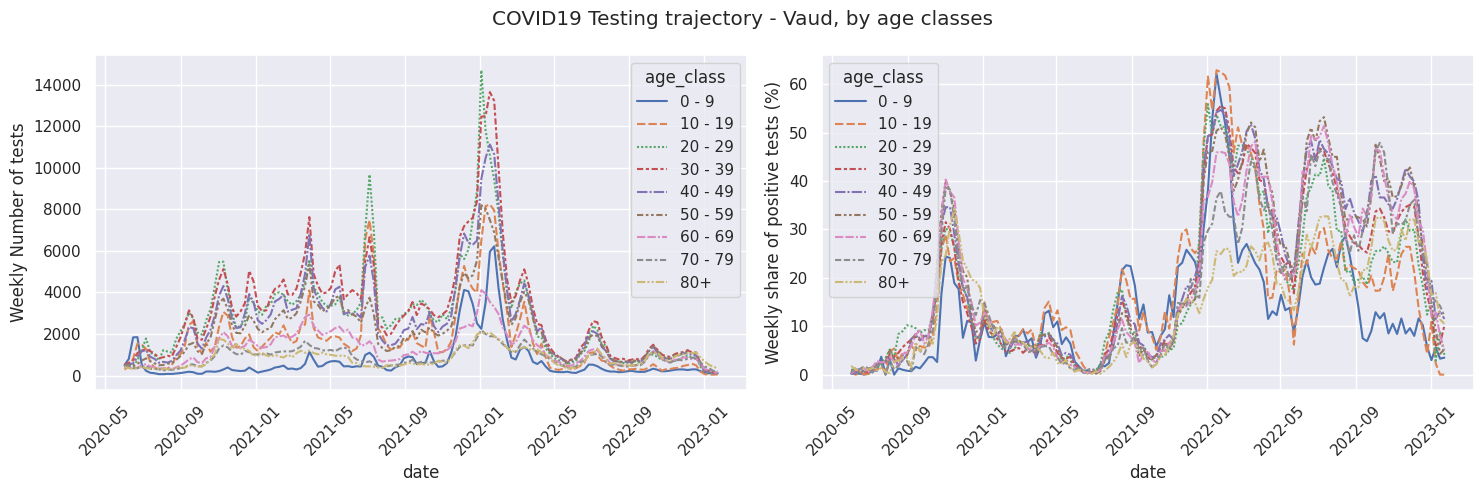

In [20]:
plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('COVID19 Testing trajectory - Vaud, by age classes')
plt.subplot(121)
sns.lineplot(data=test_data, x='date', y='entries', hue='age_class', style='age_class')
plt.ylabel('Weekly Number of tests')
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(data=test_data, x='date', y='positive_prct', hue='age_class', style='age_class')
plt.ylabel('Weekly share of positive tests (%)')
plt.xticks(rotation=45)
plt.show()

There is actually a duplicate week in the data (which I found while exploring):

In [21]:
a = test_data.query('age_class == "0 - 9"')
a[a.index.duplicated(keep=False)]

,age_class,entries,entries_pos,entries_neg,positive_prct
date,,,,,
2021-01-04,0 - 9,126.0,14.0,112.0,11.1
2021-01-04,0 - 9,152.0,16.0,136.0,10.5


We need to know whether we should sum these rows or discard one of them. Let's have a look at the weeks that surround them:

In [22]:
a.query('date >= "2020-12-24" and date <= "2021-01-11"')

,age_class,entries,entries_pos,entries_neg,positive_prct
date,,,,,
2020-12-28,0 - 9,260.0,19.0,241.0,7.3
2021-01-04,0 - 9,126.0,14.0,112.0,11.1
2021-01-04,0 - 9,152.0,16.0,136.0,10.5
2021-01-11,0 - 9,192.0,15.0,177.0,7.8


It seems that these rows should be summed to be coherent, and the percentages of positive tests needs to be re-computed:

In [23]:
test_data = test_data.groupby(['date', 'age_class'])[['entries', 'entries_pos', 'entries_neg']].sum().reset_index()
# Re-computes the proportion of positive tests
test_data['pos_share'] = test_data['entries_pos'] / test_data['entries']
test_data = test_data.set_index('date')
test_data.head()

,age_class,entries,entries_pos,entries_neg,pos_share
date,,,,,
2020-06-01,0 - 9,494.0,1.0,493.0,0.002024
2020-06-01,10 - 19,290.0,2.0,288.0,0.006897
2020-06-01,20 - 29,419.0,4.0,415.0,0.009547
2020-06-01,30 - 39,528.0,2.0,526.0,0.003788
2020-06-01,40 - 49,465.0,3.0,462.0,0.006452


We now have one final problem to solve: the data has a weekly frequency; however the models work with daily data. Therefore, we'll resample it and interpolate the daily data linearly:

In [24]:
daily_test_data = test_data.groupby('age_class')[['entries', 'entries_pos', 'entries_neg', 'pos_share']].resample('D').interpolate()
daily_test_data = daily_test_data.reset_index().set_index('date')
daily_test_data.head(20)

,age_class,entries,entries_pos,entries_neg,pos_share
date,,,,,
2020-06-01,0 - 9,494.000000,1.000000,493.000000,0.002024
2020-06-02,0 - 9,538.571429,1.000000,537.571429,0.001912
2020-06-03,0 - 9,583.142857,1.000000,582.142857,0.001800
2020-06-04,0 - 9,627.714286,1.000000,626.714286,0.001688
2020-06-05,0 - 9,672.285714,1.000000,671.285714,0.001577
2020-06-06,0 - 9,716.857143,1.000000,715.857143,0.001465
2020-06-07,0 - 9,761.428571,1.000000,760.428571,0.001353
2020-06-08,0 - 9,806.000000,1.000000,805.000000,0.001241
2020-06-09,0 - 9,953.428571,1.428571,952.000000,0.001374


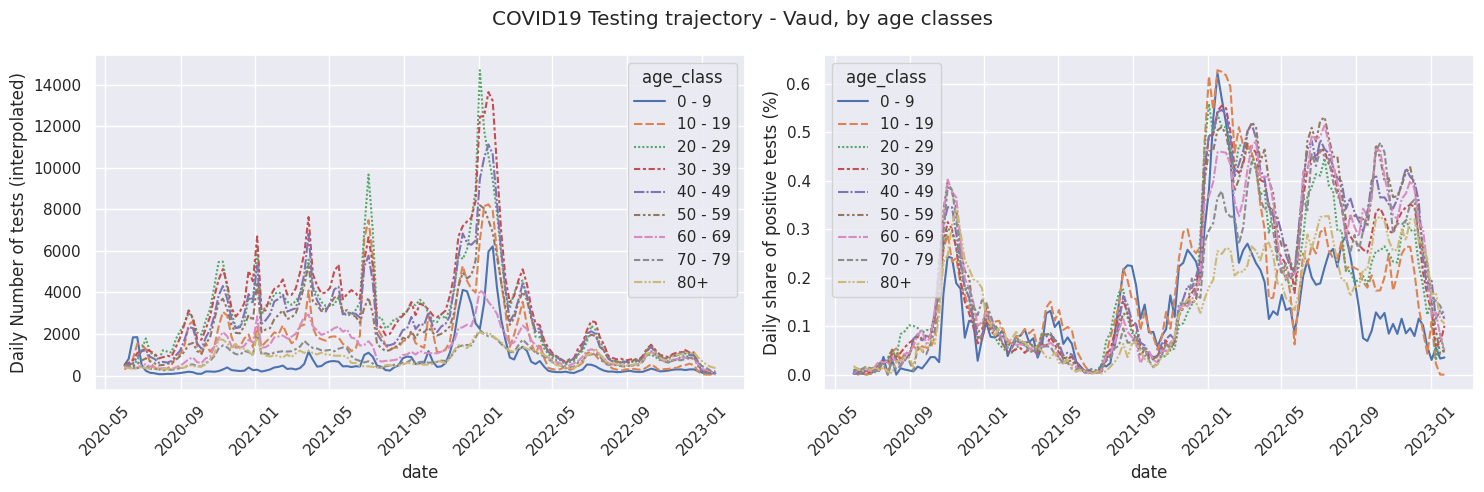

In [25]:
plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('COVID19 Testing trajectory - Vaud, by age classes')
plt.subplot(121)
sns.lineplot(data=test_data, x='date', y='entries', hue='age_class', style='age_class')
plt.ylabel('Daily Number of tests (interpolated)')
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(data=test_data, x='date', y='pos_share', hue='age_class', style='age_class')
plt.ylabel('Daily share of positive tests (%)')
plt.xticks(rotation=45)
plt.show()

In [26]:
daily_test_data.to_csv('../data/abm/vaud/prepared/vaud_daily_tests_data.csv')

# Filtering the activities per period
For convenience when we run the model, we'll save the activities in a specific file for each period.

In [27]:
# FIRST STEP: Filter all activities geographically
kept_rows = []
chunksize = 20000000
with pd.read_csv("../data/preprocessed/preprocessed_activities.csv.gz",
                 chunksize=chunksize) as full_df:
    for k, chunk in enumerate(full_df):
        # Selects in the chunk the activities performed by agents
        # that are in the sample
        chunk = chunk[chunk['id'].isin(sample_ids)]
        kept_rows.append(chunk)
        print(f'Processed {k} chunks - {chunksize * k} rows')
sample_activities = pd.concat(kept_rows)
print(sample_activities.info())

Processed 0 chunks - 0 rows
Processed 1 chunks - 20000000 rows
Processed 2 chunks - 40000000 rows
Processed 3 chunks - 60000000 rows
Processed 4 chunks - 80000000 rows
Processed 5 chunks - 100000000 rows
Processed 6 chunks - 120000000 rows
Processed 7 chunks - 140000000 rows
Processed 8 chunks - 160000000 rows
Processed 9 chunks - 180000000 rows
Processed 10 chunks - 200000000 rows
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21355565 entries, 2009379 to 176176993
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        int64 
 1   type      object
 2   facility  object
 3   age       int64 
 4   period    object
dtypes: int64(2), object(3)
memory usage: 977.6+ MB
None


We'll save that filtered data:

In [28]:
sample_activities.to_csv('../data/abm/vaud/prepared/vaud_period_activities.csv.gz', index=False)